In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random
from jax import nn

import matplotlib.pyplot as plt

from nn_functions import init_network_params, pack_params, layer_sizes
from nn_functions import update_rmsprop, update_sgd, update_adam
from nn_functions import get_batches, loss, batched_predict
from nn_functions import top_eigenvalue
from complex_nn import train_nn

In [3]:
params, log_train, grads_norm, hess_max, all_hidden_activations = train_nn(
    update_method='rmsprop',
    regularization='lasso',
    num_epochs=15,
    step_size=0.001,
    batch_size=32,
    use_adaptive_step_size=True,

    optimizer_params={'beta1': 0.99, 'beta2': 0.999, 'epsilon': 1e-8},
)

Epoch 0 — Loss: 1.0572e-01  |  ‖grad‖: 1.6100e+00  |  λ_max(H): 8.4660e+01
Epoch 1 — Loss: 8.2139e-02  |  ‖grad‖: 1.1238e+00  |  λ_max(H): 7.5832e+01
Epoch 2 — Loss: 6.5920e-02  |  ‖grad‖: 9.3552e-01  |  λ_max(H): 7.1983e+01
Epoch 3 — Loss: 6.1725e-02  |  ‖grad‖: 8.6623e-01  |  λ_max(H): 7.0796e+01
Epoch 4 — Loss: 6.0691e-02  |  ‖grad‖: 8.2004e-01  |  λ_max(H): 6.8925e+01
Epoch 5 — Loss: 5.9808e-02  |  ‖grad‖: 6.9834e-01  |  λ_max(H): 6.7429e+01
Epoch 6 — Loss: 5.9980e-02  |  ‖grad‖: 6.3037e-01  |  λ_max(H): 6.6337e+01
Epoch 7 — Loss: 5.7643e-02  |  ‖grad‖: 5.9848e-01  |  λ_max(H): 6.5755e+01
Epoch 8 — Loss: 5.7247e-02  |  ‖grad‖: 5.8142e-01  |  λ_max(H): 6.5464e+01
Epoch 9 — Loss: 5.7064e-02  |  ‖grad‖: 5.7454e-01  |  λ_max(H): 6.5328e+01
Epoch 10 — Loss: 5.6982e-02  |  ‖grad‖: 5.7816e-01  |  λ_max(H): 6.5301e+01
Epoch 11 — Loss: 5.6940e-02  |  ‖grad‖: 5.7285e-01  |  λ_max(H): 6.5284e+01
Epoch 12 — Loss: 5.6935e-02  |  ‖grad‖: 5.7450e-01  |  λ_max(H): 6.5283e+01
Epoch 13 — Loss: 5.693

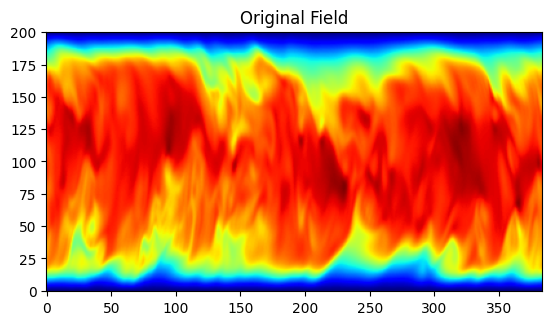

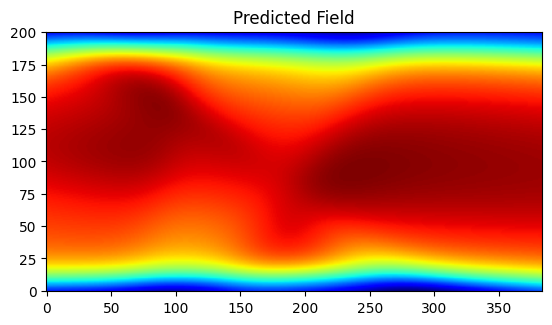

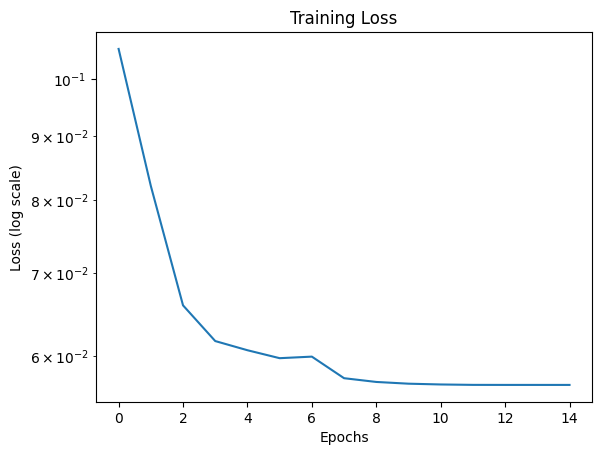

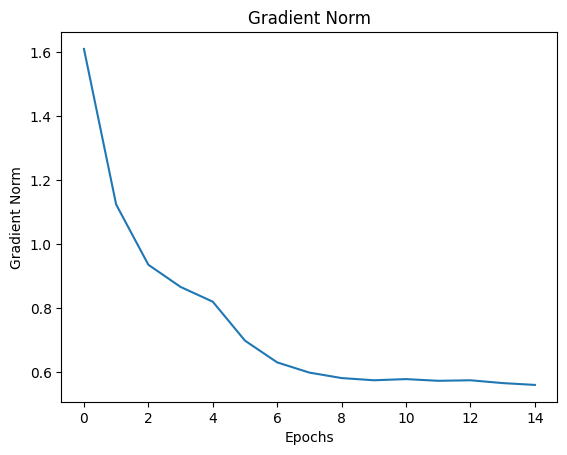

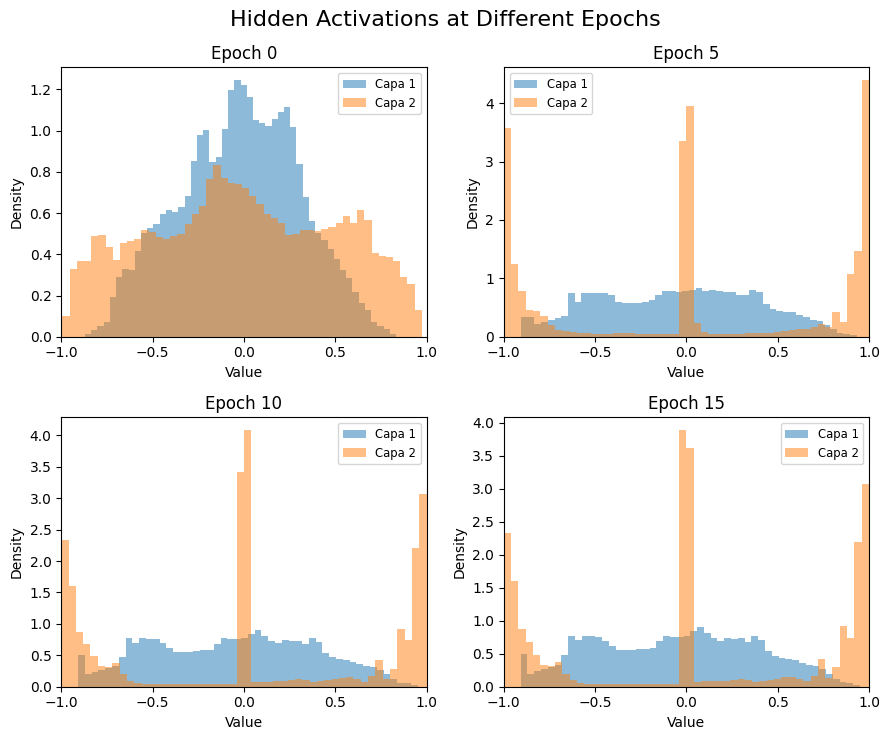

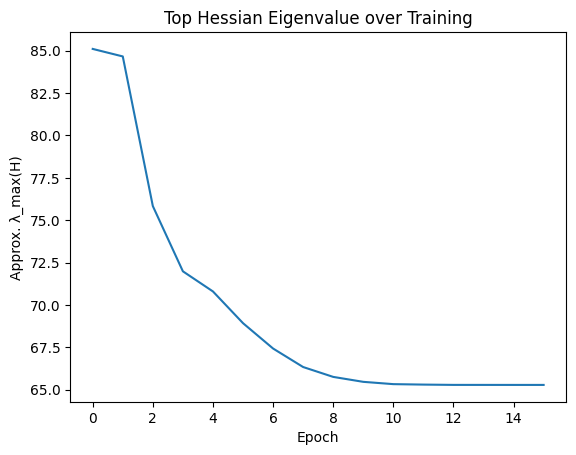

In [4]:
# Load data
field = jnp.load('field.npy')
field = field - field.mean()
field = field / field.std()
field = jnp.array(field, dtype=jnp.float32)
nx, ny = field.shape
xx = jnp.linspace(-1, 1, nx)
yy = jnp.linspace(-1, 1, ny)
xx, yy = jnp.meshgrid(xx, yy, indexing='ij')
xx = jnp.concatenate([xx.reshape(-1, 1), yy.reshape(-1, 1)], axis=1)
ff = field.reshape(-1, 1)

# Plot results
plt.figure()
plt.title('Original Field')
plt.imshow(ff.reshape((nx, ny)).T, origin='lower', cmap='jet')

plt.figure()
plt.title('Predicted Field')
plt.imshow(batched_predict(params, xx)[0].reshape((nx, ny)).T, origin='lower', cmap='jet')

# Plot loss function
plt.figure()
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (log scale)')
plt.semilogy(log_train)

# Plot gradient norm
plt.figure()
plt.title('Gradient Norm')
plt.xlabel('Epochs')
plt.ylabel('Gradient Norm')
plt.plot(grads_norm)

# Especifica los epochs que quieres plotear
epochs_to_plot = [0, 5, 10, 15]
fig, axes = plt.subplots(2, 2, figsize=(12*.75, 10*.75), squeeze=False)
for ax, epoch in zip(axes.flatten(), epochs_to_plot):
    hidden_activations = all_hidden_activations[epoch]
    flat0 = hidden_activations[0].ravel()
    flat1 = hidden_activations[1].ravel()
    ax.hist(flat0, bins=50, alpha=0.5, density=True, label='Capa 1')
    ax.hist(flat1, bins=50, alpha=0.5, density=True, label='Capa 2')
    ax.set_title(f'Epoch {epoch}')
    ax.set_xlim(-1, 1)
    ax.set_xticks([-1, -0.5, 0, 0.5, 1])
    ax.set_xlabel('Value')
    ax.set_ylabel('Density')
    ax.legend(fontsize='small')

plt.suptitle('Hidden Activations at Different Epochs', fontsize=16)
plt.tight_layout()

# --- plot how λ_max evolves ---
plt.figure()
plt.plot(hess_max)
plt.xlabel("Epoch")
plt.ylabel("Approx. λ_max(H)")
plt.title("Top Hessian Eigenvalue over Training")

# Show all plots
plt.show()